# Regressor methods, week 12 demo

## Libraries and settings

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

## Housing data

In [52]:
# for Regression need target variable that is numerical continuous (not categorical)

# Corrected Boston Housing data by Bivand, Nowosad and Lovelace
# https://jakubnowosad.com/spData/reference/boston.html
dfo = pd.read_csv("data/boston_corrected.tsv", sep='\t', skiprows=9)

In [53]:
dfo.columns

Index(['OBS.', 'TOWN', 'TOWN#', 'TRACT', 'LON', 'LAT', 'MEDV', 'CMEDV', 'CRIM',
       'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [54]:
# first 7 columns are not needed, being
# [obs]ervation id, geographical, and uncorrected housing value
df = dfo.drop(['OBS.', 'LON', 'LAT', 'TRACT', 'TOWN', 'TOWN#', 'MEDV'], axis=1, inplace=False)

In [55]:
df.head(1)

,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296,15.3,396.9,4.98


In [56]:
# target variable is CMEDV median value of housing in area
y = df.CMEDV
print(y.shape)

(506,)


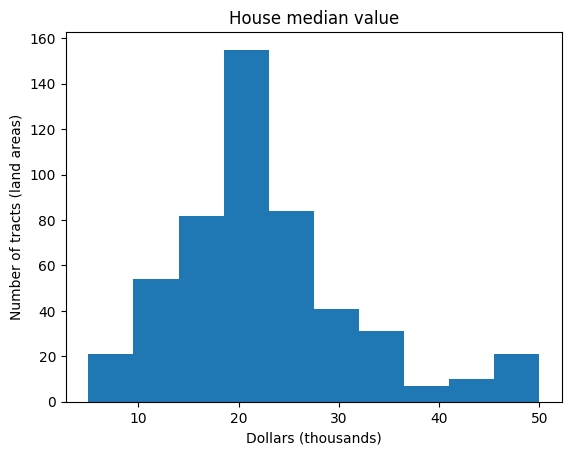

In [57]:
# distribution of target
plt.hist(df.CMEDV)
plt.title('House median value')
plt.xlabel('Dollars (thousands)')
plt.ylabel('Number of tracts (land areas)')
plt.show()

In [58]:
#  three integer columns, are any categorical?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CMEDV    506 non-null    float64
 1   CRIM     506 non-null    float64
 2   ZN       506 non-null    float64
 3   INDUS    506 non-null    float64
 4   CHAS     506 non-null    int64  
 5   NOX      506 non-null    float64
 6   RM       506 non-null    float64
 7   AGE      506 non-null    float64
 8   DIS      506 non-null    float64
 9   RAD      506 non-null    int64  
 10  TAX      506 non-null    int64  
 11  PTRATIO  506 non-null    float64
 12  B        506 non-null    float64
 13  LSTAT    506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [14]:
# adjacent to Charles River is categorical
df.CHAS.value_counts()

CHAS
0    471
1     35
Name: count, dtype: int64

In [15]:
df.RAD.unique()

array([ 1,  2,  3,  5,  4,  8,  6,  7, 24])

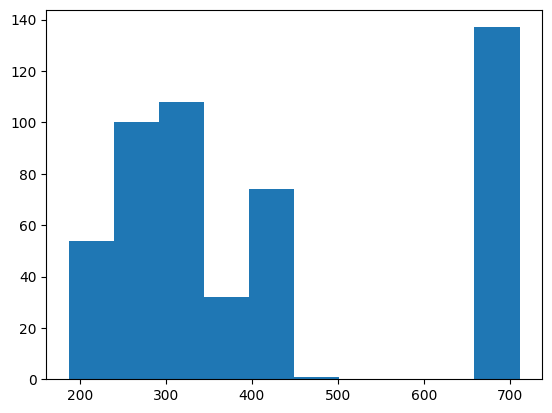

In [16]:
plt.hist(df.TAX)
plt.show()

In [17]:
# find which features correlate with target more (+ or -)
df.corr()

,CMEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
CMEDV,1.000000,-0.389582,0.360386,-0.484754,0.175663,-0.429300,0.696304,-0.377999,0.249315,-0.384766,-0.471979,-0.505655,0.334861,-0.740836
CRIM,-0.389582,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621
ZN,0.360386,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995
INDUS,-0.484754,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800
CHAS,0.175663,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929
NOX,-0.429300,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879
RM,0.696304,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808
AGE,-0.377999,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339
DIS,0.249315,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996
RAD,-0.384766,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676


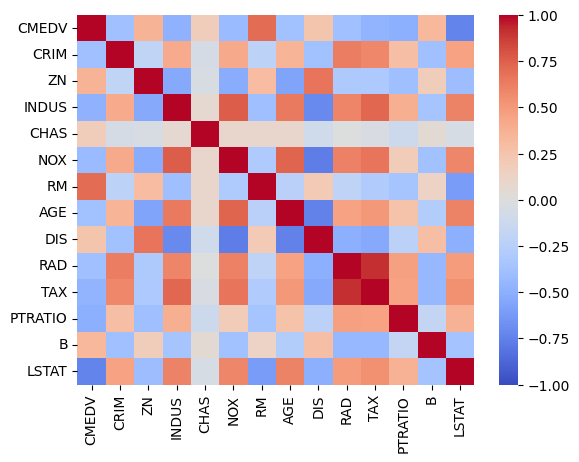

In [60]:
# sns.heatmap(df.corr(method="pearson"), annot=False)

# too many features to annotate
sns.heatmap(df.corr(method="pearson"),
            vmin=-1,
            cmap='coolwarm', # a divergent palette shows strong corr whether negative or positive
            annot=F
plt.show()

### Outliers - find any extremes in numerical features

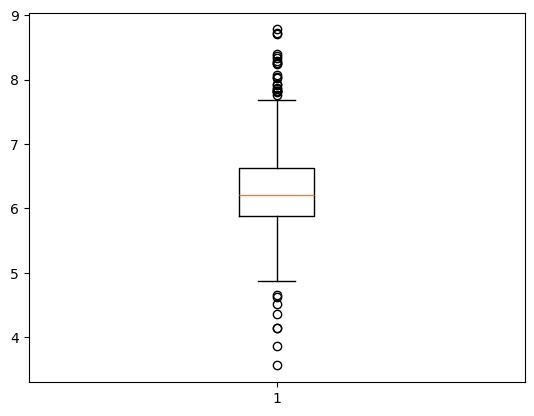

In [73]:
# view distributions of 6 most correlated features
plt.boxplot(df.RM)
plt.show()

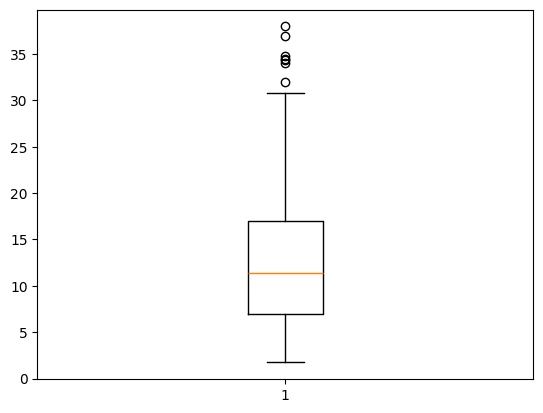

In [74]:
plt.boxplot(df.LSTAT)
plt.show()

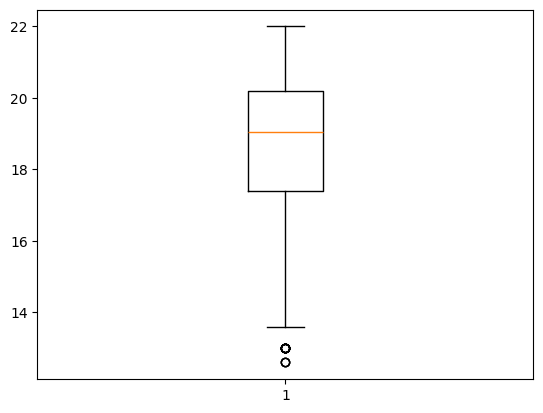

In [75]:
plt.boxplot(df.PTRATIO)
plt.show()

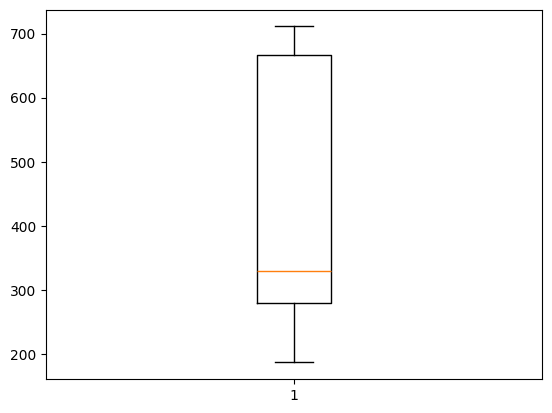

In [76]:
plt.boxplot(df.TAX)
plt.show()

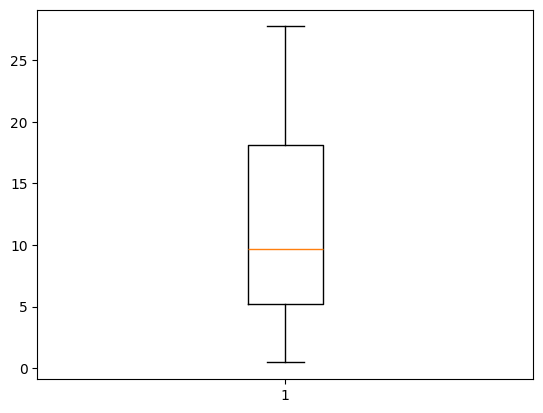

In [77]:
plt.boxplot(df.INDUS)
plt.show()

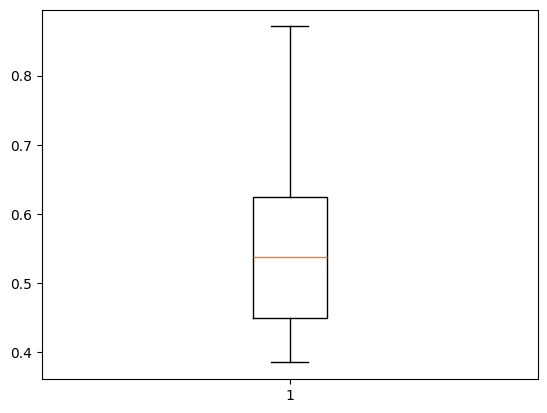

In [78]:
plt.boxplot(df.NOX)
plt.show()

## Linear Regression, only 1 feature

In [62]:
# one feature only (lower "working class" % in population)
# x1 = np.array(df.LSTAT).reshape(-1,1)
x1 = pd.DataFrame(df['LSTAT'])
print(x1.shape)
print(type(x1))

(506, 1)
<class 'pandas.core.frame.DataFrame'>


In [63]:
# scaling not needed for Linear regression
x1_train, x1_test, y_train, y_test = train_test_split(x1, y, test_size=0.2, random_state=42)
print("x1_train shape: {}, y_train shape: {}".format(x1_train.shape, y_train.shape))
print("x1_test shape: {}, y_test shape {}".format(x1_test.shape, y_test.shape))

x1_train shape: (404, 1), y_train shape: (404,)
x1_test shape: (102, 1), y_test shape (102,)


In [64]:
model = LinearRegression()
model.fit(x1_train, y_train)

LinearRegression()

In [65]:
print(model.coef_)
print(model.intercept_)

[-0.9689]
34.87134431878069


In [66]:
y_pred = model.predict(x1_test).reshape(-1,1)
print(y_pred.shape)
y_pred[:3]

(102, 1)


array([[26.1127],
       [31.4512],
       [17.3638]])

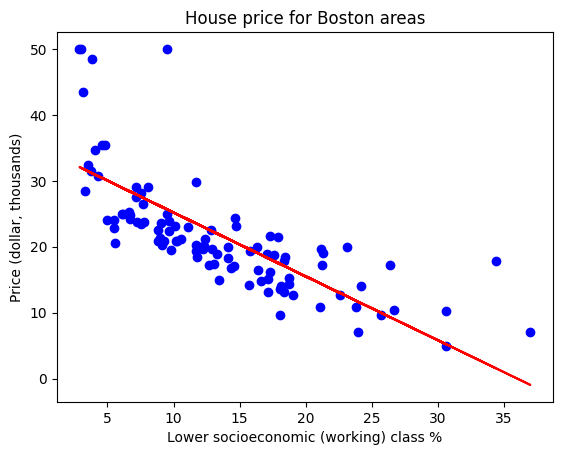

In [68]:
plt.scatter(x1_test, y_test, color='blue')
plt.plot(x1_test, y_pred, color='red')
plt.title("House price for Boston areas")
plt.xlabel("Lower socioeconomic (working) class %")
plt.ylabel("Price (dollar, thousands)")
plt.show()

In [153]:
# a baseline metric
mean_squared_error(y_test, y_pred)

33.718513849773416

In [155]:
# R-squared
r2_score(y_test, y_pred)

0.5427642306533597

## Linear Regression, another single feature

In [28]:
# one feature only (mean number of rooms per house)
x1 = pd.DataFrame(df['RM'])
print(x1.shape)

(506, 1)


In [29]:
x1_train, x1_test, y_train, y_test = train_test_split(x1, y, test_size=0.2, random_state=42)

In [158]:
model = LinearRegression()
model.fit(x1_train, y_train)

LinearRegression()

In [159]:
print(model.coef_)
print(model.intercept_)

[9.3449]
-36.21968671198455


In [160]:
y_pred = model.predict(x1_test).reshape(-1,1)

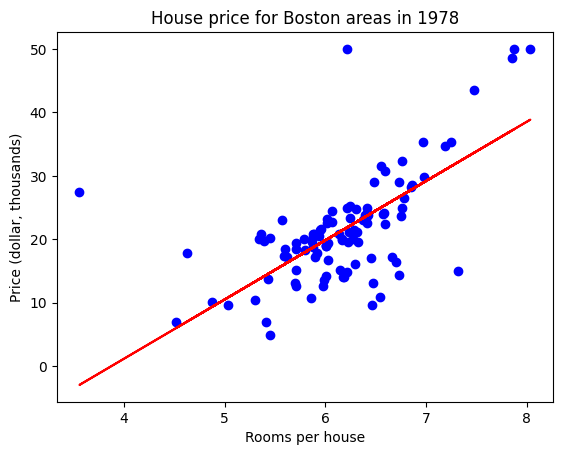

In [161]:
plt.scatter(x1_test, y_test, color='blue')
plt.plot(x1_test, y_pred, color='red')
plt.title("House price for Boston areas in 1978")
plt.xlabel("Rooms per house")
plt.ylabel("Price (dollar, thousands)")
plt.show()

In [162]:
mean_squared_error(y_test, y_pred)

46.630761887451115

In [136]:
# R-squared
r2_score(y_test, y_pred)

0.36766927564418794

## Polynomial regression

In [20]:
# x1.sort_values(by=['RM'], inplace=True, ascending=True)

In [30]:
poly_features = PolynomialFeatures(degree=2)
x1_train_poly = poly_features.fit_transform(x1_train)
poly_model = LinearRegression()
poly_model.fit(x1_train_poly, y_train)

LinearRegression()

In [32]:
y_train_pred = poly_model.predict(x1_train_poly)
y_test_pred = poly_model.predict(poly_features.fit_transform(x1_test))

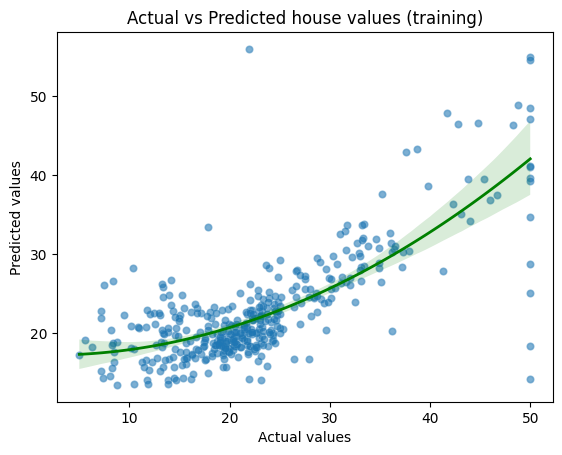

In [41]:
# following https://www.kaggle.com/code/kunalc101/boston-housing-linear-and-polynomial-regression
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.4)
sns.regplot(x=y_train, y=y_train_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, order=2)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted house values (training)")
plt.show()

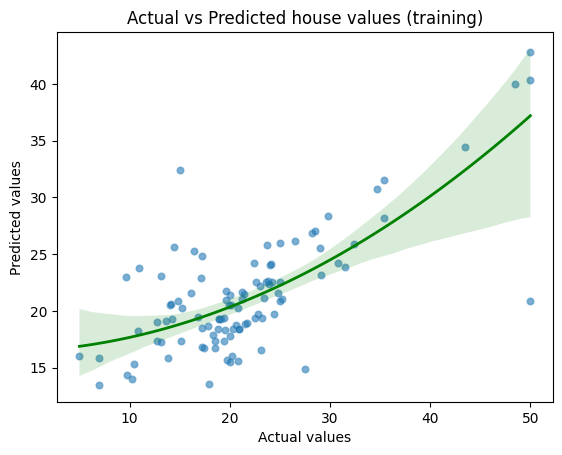

In [42]:
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_test_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, order=2)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted house values (training)")
plt.show()

In [39]:
# Polynomial is better than Linear Regression in this example
mean_squared_error(y_test, y_test_pred)

35.782850156515

## Multiple/all features for Linear Regression

In [44]:
# CRIM = crime rate; LSTAT = working class; NOX = air quality; PTRATIO = pupil:teacher ratio; DIS = distance to employment centres; RAD = radial road proximity; RM = rooms
# X = df[['ZN', 'TAX', 'CRIM', 'DIS', 'LSTAT', 'NOX', 'PTRATIO', 'RAD', 'RM']]
X = df.drop('CMEDV', axis=1)
print(X.shape)

(506, 13)


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape))
print("X_test shape: {}, y_test shape {}".format(X_test.shape, y_test.shape))

X_train shape: (404, 13), y_train shape: (404,)
X_test shape: (102, 13), y_test shape (102,)


In [184]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [185]:
y_pred = model.predict(X_test).reshape(-1,1)
y_pred.shape

(102, 1)

In [186]:
print(model.coef_)
print(model.intercept_)

[-0.1062 0.0477 0.0233 2.6917 -17.7426 3.7894 0.0006 -1.5018 0.3038
 -0.0127 -0.9239 0.0092 -0.5307]
36.371891589434654


In [188]:
# better than any of those single-feature regressions (Linear or Polynomial)
mean_squared_error(y_test, y_pred)

22.004825142821154

In [187]:
# R squared
r2 = r2_score(y_test, y_pred)
print(r2)

0.7016062689375102


In [180]:
# adjust R-squared
print(f"{X.shape[1]} features")
1 - (1-r2) * (len(y)-1) / (len(y)-X.shape[1] -1)

13 features


0.6937218817346396

## Polynomial regression with all features

In [46]:
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

LinearRegression()

In [47]:
y_train_pred = poly_model.predict(X_train_poly)
y_test_pred = poly_model.predict(poly_features.fit_transform(X_test))

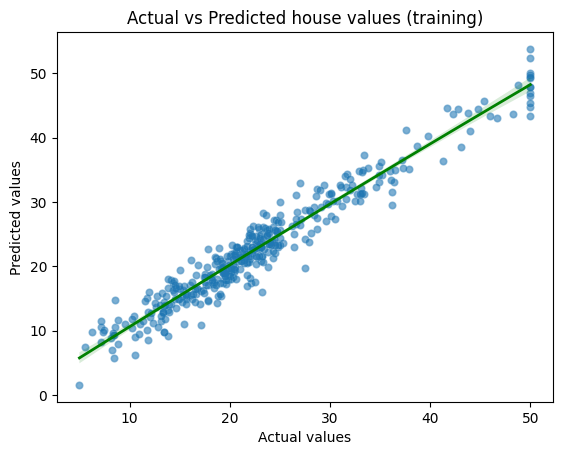

In [48]:
# following pattern at https://www.kaggle.com/code/kunalc101/boston-housing-linear-and-polynomial-regression
sns.scatterplot(x=y_train, y=y_train_pred, alpha=0.4)
sns.regplot(x=y_train, y=y_train_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, order=2)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted house values (training)")
plt.show()

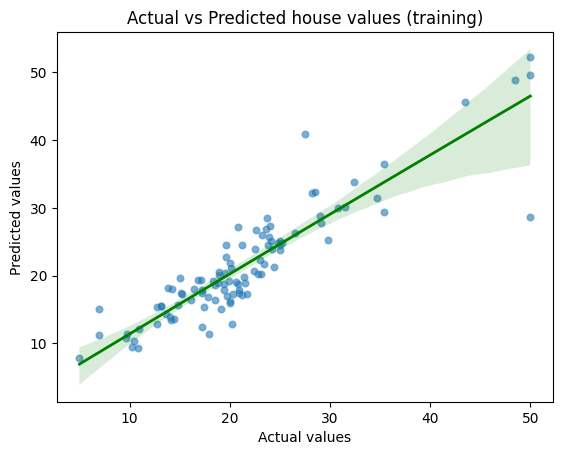

In [49]:
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.4)
sns.regplot(x=y_test, y=y_test_pred, scatter_kws={'s': 20, 'alpha':0.3}, line_kws={'color':'green', 'linewidth': 2}, order=2)
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.title("Actual vs Predicted house values (training)")
plt.show()

In [50]:
# Polynomial on all features is best model so far
mean_squared_error(y_test, y_test_pred)

13.977488539931771

### try regularization to check overfitting

In [191]:
from sklearn.linear_model import Lasso, Ridge

In [193]:
# worse than unregulated, suggests all features at least slightly relevant
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
mean_squared_error(y_test, y_pred_lasso)

25.496868081469945

In [194]:
# also worse than unregulated
ridge = Ridge(alpha=0.5)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
mean_squared_error(y_test, y_pred_ridge)

24.64247233233699

## Decision Tree Regressor

In [215]:
model = DecisionTreeRegressor(max_depth=5, random_state=42)

In [216]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

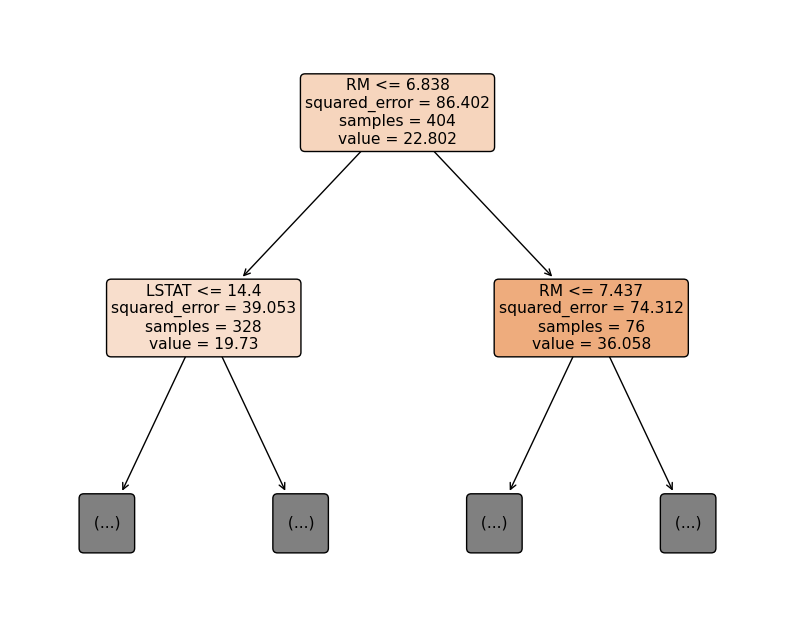

In [217]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10,8))
plot_tree(model, max_depth=1, feature_names=X.columns, rounded=True, filled=True)
plt.show()

In [218]:
# better than any previous Regression models
mean_squared_error(y_test, y_pred)

9.344585439439657

In [219]:
# may need scaling due to high variance in LSTAT
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [220]:
model = DecisionTreeRegressor(max_depth=5, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

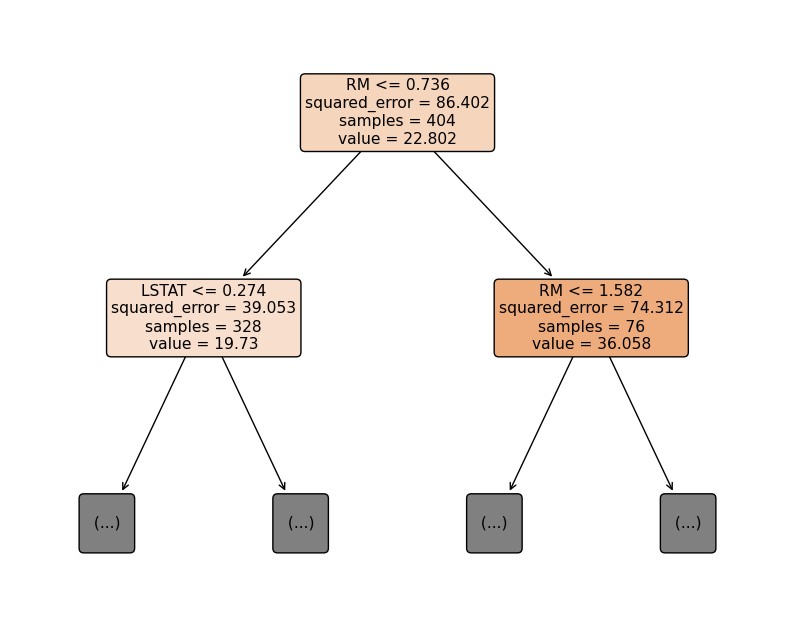

In [221]:
plt.figure(figsize=(10,8))
plot_tree(model, max_depth=1, feature_names=X.columns, rounded=True, filled=True)
plt.show()

In [224]:
# MSE exactly same, perhaps I made a mistake?
mean_squared_error(y_test, y_pred)

9.344585439439657

## Random Forest Regressor

In [231]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42)

In [232]:
model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=5, n_estimators=200, random_state=42)

In [238]:
model.feature_importances_
# RM and LSTAT are still most important features

array([0.0335, 0.0012, 0.0032, 0.0010, 0.0136, 0.5220, 0.0098, 0.0535,
       0.0022, 0.0117, 0.0118, 0.0070, 0.3294])

In [234]:
# forest does not improve on single Decision Tree
y_pred = model.predict(X_test_scaled)
mean_squared_error(y_test, y_pred)

9.682604429298394

## K-fold & cross-validation

In [255]:
from sklearn.model_selection import KFold, cross_val_score
# from sklearn import linear_model

In [266]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = DecisionTreeRegressor(max_depth=5, random_state=42)
# model.fit(X_train_scaled, y_train)

In [269]:
# worse than plain Decision Tree
score = -1 * cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring="neg_mean_squared_error")
print(f'Scores for each fold: {score}')

Scores for each fold: [42.2950 17.1560 35.7130 31.3227 17.8674]


## GridSearchCV with K-fold 

In [242]:
# spoiler - this doesn't help
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit

In [244]:
def fit_model(X, y):

    # make cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 0)

    regressor = DecisionTreeRegressor()

    params = {'max_depth': range(1,11)}

    # make a grid search object
    grid = GridSearchCV(regressor, param_grid=params, cv=cv_sets)

    grid = grid.fit(X, y)

    return grid.best_estimator_

In [245]:
model = fit_model(X_train_scaled, y_train)

In [250]:
print("Parameter 'max_depth' is {} for the optimal model.".format(model.get_params()['max_depth']))

Parameter 'max_depth' is 8 for the optimal model.


In [251]:
model = DecisionTreeRegressor(max_depth=8, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

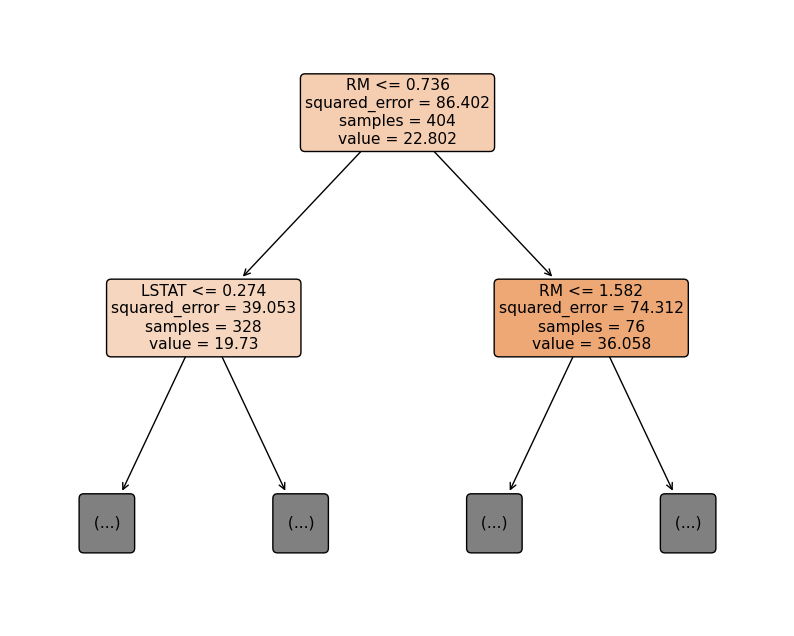

In [252]:
plt.figure(figsize=(10,8))
plot_tree(model, max_depth=1, feature_names=X.columns, rounded=True, filled=True)
plt.show()

In [253]:
# nearly as good as a simple decision tree!
mean_squared_error(y_test, y_pred)

9.638661295020915

### Among the models tested, Decision Tree is simple and best